In [153]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

from src.data import *
from src.plotting import *

In [154]:
kallus_func = lambda X,U,T,eps: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2+2*U*X+0.5*eps


cfoundeded_func = lambda X,T: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2+2*(T-0.5)*X**2
uncfounded_func = lambda X,T: 1+T+X+2*T*X+0.5*X**2+0.75*T*X**2

kallus_outcome_funcs = outcome_funcs(cfounded_func=cfoundeded_func,
              uncfounded_func=uncfounded_func)

T_prop = 0.5
n_samples_exp = 200
n_samples_obs = 1000

In [155]:
exp_data,obs_data,outcome_funcs_GP = get_train_data_GP_1d(kallus_outcome_funcs,
                         n_samples_exp = n_samples_exp,n_samples_obs = n_samples_obs, 
                         exp_range = (-1,1),obs_range = (-3,3),
                         T_prop = T_prop,train_data = None)

(<Figure size 1600x400 with 3 Axes>,
 array([<Axes: title={'center': 'Observational Data'}, xlabel='X', ylabel='Y'>,
        <Axes: title={'center': 'Experimental Data'}, xlabel='X'>,
        <Axes: title={'center': 'Pseudo Outcomes'}, xlabel='X'>],
       dtype=object))

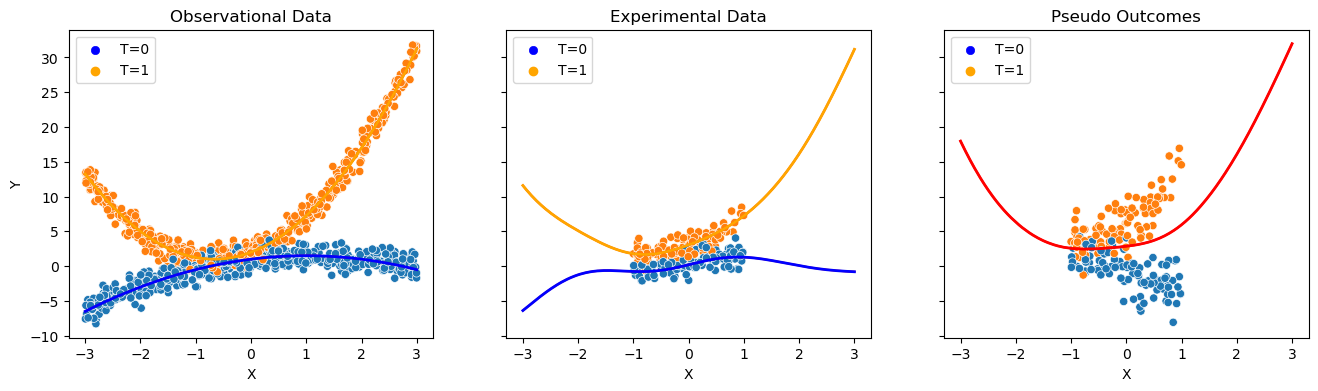

In [156]:
obs_exp_pseudo_plot(obs_data,exp_data,outcome_funcs_GP,T_prop=T_prop)

In [157]:
exp_data_adjusted = adjust_data(exp_data,kallus_outcome_funcs.cfounded_func)
pseudo_adjust_data = get_pseudo_outcome_data(exp_data_adjusted,T_prop=T_prop)

train_x0 = get_conditioned_data(pseudo_adjust_data,T_val=0).X
train_x1 = get_conditioned_data(pseudo_adjust_data,T_val=1).X

train_y0 = get_conditioned_data(pseudo_adjust_data,T_val=0).Y
train_y1 = get_conditioned_data(pseudo_adjust_data,T_val=1).Y

In [158]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=2, rank=1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)
    
    def CATE(self,x):
        model(test_x, test_i_task1).stddev.detach()
        return 

likelihood = gpytorch.likelihoods.GaussianLikelihood()

train_i_task1 = torch.full((train_x0.shape[0],1), dtype=torch.long, fill_value=0)
train_i_task2 = torch.full((train_x1.shape[0],1), dtype=torch.long, fill_value=1)

full_train_x = torch.cat([train_x0, train_x1])
full_train_i = torch.cat([train_i_task1, train_i_task2])
full_train_y = torch.cat([train_y0, train_y1])

# Here we have two iterms that we're passing in as train_inputs
model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)

In [159]:
# this is for running the notebook in our testing framework
import os

smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(full_train_x, full_train_i)
    loss = -mll(output, full_train_y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 3.553
Iter 2/50 - Loss: 3.392
Iter 3/50 - Loss: 3.250
Iter 4/50 - Loss: 3.124
Iter 5/50 - Loss: 3.012
Iter 6/50 - Loss: 2.914
Iter 7/50 - Loss: 2.827
Iter 8/50 - Loss: 2.750
Iter 9/50 - Loss: 2.683
Iter 10/50 - Loss: 2.624
Iter 11/50 - Loss: 2.572
Iter 12/50 - Loss: 2.527
Iter 13/50 - Loss: 2.487
Iter 14/50 - Loss: 2.452
Iter 15/50 - Loss: 2.421
Iter 16/50 - Loss: 2.394
Iter 17/50 - Loss: 2.370
Iter 18/50 - Loss: 2.349
Iter 19/50 - Loss: 2.330
Iter 20/50 - Loss: 2.314
Iter 21/50 - Loss: 2.298
Iter 22/50 - Loss: 2.284
Iter 23/50 - Loss: 2.271
Iter 24/50 - Loss: 2.259
Iter 25/50 - Loss: 2.249
Iter 26/50 - Loss: 2.239
Iter 27/50 - Loss: 2.229
Iter 28/50 - Loss: 2.221
Iter 29/50 - Loss: 2.214
Iter 30/50 - Loss: 2.207
Iter 31/50 - Loss: 2.201
Iter 32/50 - Loss: 2.195
Iter 33/50 - Loss: 2.190
Iter 34/50 - Loss: 2.186
Iter 35/50 - Loss: 2.181
Iter 36/50 - Loss: 2.177
Iter 37/50 - Loss: 2.174
Iter 38/50 - Loss: 2.170
Iter 39/50 - Loss: 2.166
Iter 40/50 - Loss: 2.163
Iter 41/5

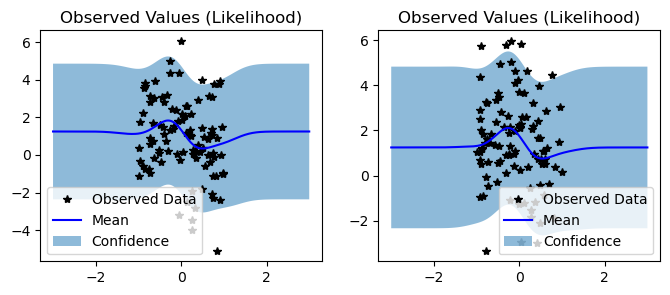

In [160]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Test points every 0.02 in [0,1]
test_x = torch.linspace(-3, 3, 200)
test_i_task0 = torch.full((test_x.shape[0],1), dtype=torch.long, fill_value=0)
test_i_task1 = torch.full((test_x.shape[0],1), dtype=torch.long, fill_value=1)

# Make predictions - one task at a time
# We control the task we cae about using the indices

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_y0 = likelihood(model(test_x, test_i_task0))
    observed_pred_y1 = likelihood(model(test_x, test_i_task1))

# Define plotting function
def ax_plot(ax, train_y, train_x, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.detach().numpy(), rand_var.mean.detach().numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    # ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

# Plot both tasks
ax_plot(y1_ax, train_y0, train_x0, observed_pred_y0, 'Observed Values (Likelihood)')
ax_plot(y2_ax, train_y1, train_x1, observed_pred_y1, 'Observed Values (Likelihood)')

In [167]:
model(test_x, test_i_task1).mean.detach()

tensor([1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2441, 1.2441, 1.2442, 1.2443, 1.2445, 1.2447,
        1.2449, 1.2453, 1.2457, 1.2462, 1.2469, 1.2476, 1.2486, 1.2496, 1.2509,
        1.2523, 1.2538, 1.2555, 1.2573, 1.2593, 1.2613, 1.2634, 1.2655, 1.2676,
        1.2697, 1.2717, 1.2737, 1.2756, 1.2774, 1.2794, 1.2814, 1.2837, 1.2864,
        1.2898, 1.2941, 1.2996, 1.3066, 1.3155, 1.3267, 1.3404, 1.3571, 1.3770,
        1.4005, 1.4277, 1.4587, 1.4936, 1.5322, 1.5742, 1.6193, 1.6670, 1.7166,
        1.7672, 1.8181, 1.8681, 1.9162, 1.9612, 2.0020, 2.0374, 2.0663, 2.0877,
        2.1007, 2.1046, 2.0988, 2.0830, 2.0570, 2.0210, 1.9754, 1.9208, 1.8579,
        1.7879, 1.7120, 1.6315, 1.5479, 1.4627, 1.3775, 1.2938, 1.2129, 1.1363,
        1.0649, 0.9999, 0.9419, 0.8915, 

In [165]:
model.CATE(test_x).mean.detach()

tensor([1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440, 1.2440,
        1.2440, 1.2440, 1.2440, 1.2440, 

In [162]:
model(test_x, test_i_task1).mean.detach() - model(test_x, test_i_task0).mean.detach()

tensor([1.1921e-07, 2.3842e-07, 1.1921e-07, 3.5763e-07, 5.9605e-07, 7.1526e-07,
        1.1921e-06, 1.7881e-06, 2.6226e-06, 3.8147e-06, 5.6028e-06, 8.2254e-06,
        1.1802e-05, 1.7166e-05, 2.4557e-05, 3.4928e-05, 4.9233e-05, 6.9141e-05,
        9.6440e-05, 1.3328e-04, 1.8322e-04, 2.5010e-04, 3.3867e-04, 4.5562e-04,
        6.0868e-04, 8.0740e-04, 1.0633e-03, 1.3907e-03, 1.8057e-03, 2.3279e-03,
        2.9800e-03, 3.7875e-03, 4.7793e-03, 5.9878e-03, 7.4477e-03, 9.1970e-03,
        1.1275e-02, 1.3723e-02, 1.6582e-02, 1.9890e-02, 2.3684e-02, 2.7996e-02,
        3.2850e-02, 3.8263e-02, 4.4241e-02, 5.0775e-02, 5.7844e-02, 6.5411e-02,
        7.3420e-02, 8.1801e-02, 9.0465e-02, 9.9308e-02, 1.0821e-01, 1.1705e-01,
        1.2570e-01, 1.3400e-01, 1.4183e-01, 1.4907e-01, 1.5559e-01, 1.6130e-01,
        1.6613e-01, 1.7003e-01, 1.7297e-01, 1.7498e-01, 1.7609e-01, 1.7638e-01,
        1.7594e-01, 1.7491e-01, 1.7342e-01, 1.7163e-01, 1.6971e-01, 1.6782e-01,
        1.6613e-01, 1.6480e-01, 1.6396e-

In [163]:
model(torch.concat([test_x[:1],test_x[:1]]), torch.concat([test_i_task0[:1],test_i_task1[:1]])).ker.detach()


tensor([[0.4443, 0.2579],
        [0.2579, 0.3987]])